This notebook demonstrates Bayesian Neural Network using pymc3 and theano. 

We will build a 2-layer Bayesian neural network on a toy "moon" data set created by scitik-learn.

This is a mock demo motivated by an awesome blogplot, where all the credits should be directed to: 
http://pymc3-testing.readthedocs.io/en/rtd-docs/notebooks/bayesian_neural_network_opvi-advi.html 

In [4]:
import pymc3 as pm
import theano.tensor as T
import theano
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sbn
sbn.set_style('white')
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons
from warnings import filterwarnings
filterwarnings('ignore')

In [5]:
def adjustAxeProperties(ax_obj, x_fontsize, x_rotation, y_fontsize, y_rotation):
    for tick in ax_obj.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_fontsize)
        tick.label.set_rotation(x_rotation)
    for tick in ax_obj.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_fontsize)
        tick.label.set_rotation(y_rotation)

In [6]:
floatX = theano.config.floatX

In [7]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

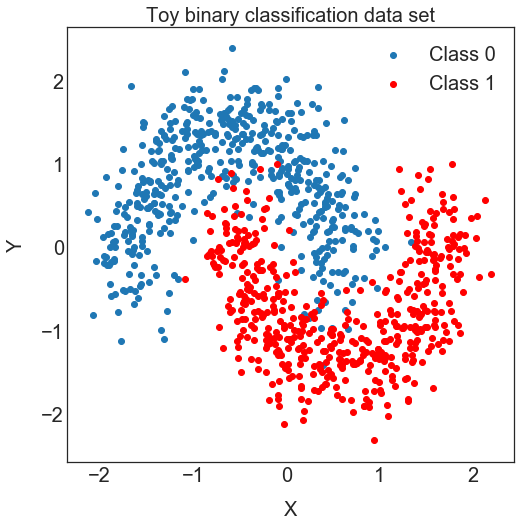

In [8]:
FONTSIZE = 20
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')

ax.legend(loc='best', fontsize=FONTSIZE)
ax.set_xlabel('X', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('Y', fontsize=FONTSIZE, labelpad=15)
adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)
_ = ax.set_title('Toy binary classification data set', fontsize=FONTSIZE)

In [9]:
def createNeuralNetwork(input_layer, output_layer):
    n_hidden_1 = 5
    n_hidden_2 = 5
    
    init_W1 = np.random.randn(X.shape[1], n_hidden_1).astype(floatX)
    init_W2 = np.random.randn(n_hidden_1, n_hidden_2).astype(floatX)
    init_W3 = np.random.randn(n_hidden_2).astype(floatX)

    
    with pm.Model() as neural_network:
        W1 = pm.Normal('W1', 0, sd=1, shape=(X.shape[1], n_hidden_1), testval=init_W1)
        W2 = pm.Normal('W2', 0, sd=1, shape=(n_hidden_1, n_hidden_2), testval=init_W2)
        W3 = pm.Normal('W3', 0, sd=1, shape=(n_hidden_2), testval=init_W3)        
                
        A1 = pm.math.tanh(pm.math.dot(input_layer, W1))        
        A2 = pm.math.tanh(pm.math.dot(A1, W2))        
        A3 = pm.math.sigmoid(pm.math.dot(A2, W3))
        
        out = pm.Bernoulli('out', A3, observed=output_layer,
                           total_size=Y_train.shape[0])
    
    return neural_network

In [10]:
# Trick: Turn inputs and outputs into shared variables.
# For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
input_layer = theano.shared(X_train)
output_layer = theano.shared(Y_train)
neural_network = createNeuralNetwork(input_layer, output_layer)

In [11]:
with neural_network:
    # Run ADVI to estimate posterior means, standard deviations, and the evidence lower bound (ELBO)
    # Use the following trick to reduce the varianc
    # For more detail, see: approximateinference.org/accepted/RoederEtAl2016.pdf
    s = theano.shared(pm.floatX(1))
    inference = pm.ADVI(cost_part_grad_scale=s)
    # ADVI has nearly converged
    pm.fit(n=20000, method=inference)
    # set `s` to zero
    s.set_value(0)
    approx = pm.fit(n=30000)    

Average Loss = 187.36: 100%|██████████| 20000/20000 [00:14<00:00, 1340.23it/s]
Finished [100%]: Average Loss = 187.23
Average Loss = 149.13: 100%|██████████| 30000/30000 [00:15<00:00, 1895.19it/s]
Finished [100%]: Average Loss = 149.3


In [12]:
trace = approx.sample(draws=5000)

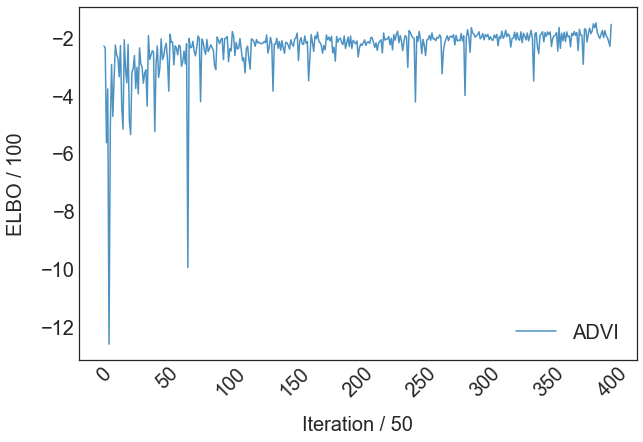

In [13]:
FONTSIZE = 20
fig, ax = plt.subplots(1, figsize=(10, 6.5))

ax.plot(-inference.hist[::50]/100, label='ADVI', alpha=.8)
plt.legend(loc='best', fontsize=FONTSIZE)
ax.set_xlabel('Iteration / 50', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('ELBO / 100', fontsize=FONTSIZE, labelpad=15)
adjustAxeProperties(ax, FONTSIZE, 45, FONTSIZE, 0)


# Use posterior predictive check (PPC) to examine the model

In [14]:
symbolic_x = T.matrix('X')
symbolic_x.tag.test_value = np.empty_like(X_train[:7])

symbolic_n = T.iscalar('n')
symbolic_n.tag.test_value = 123

_sample_proba = approx.sample_node(neural_network.out.distribution.p, size=symbolic_n,
                                   more_replacements={input_layer: symbolic_x})

sample_proba = theano.function([symbolic_x, symbolic_n], _sample_proba)

In [15]:
def realization_step1():
    input_layer.set_value(X_test)
    output_layer.set_value(Y_test)
    ppc = pm.sample_ppc(trace, model=neural_network, samples=500, progressbar=False)
    pred = ppc['out'].mean(axis=0) > 0.5
    
def realization_step2():
    sample_proba(X_test, 500).mean(0) > 0.5

In [16]:
realization_step1()
realization_step2()
pred = sample_proba(X_test, 500).mean(0) > 0.5
pred = pred.ravel()


In [17]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 94.8%


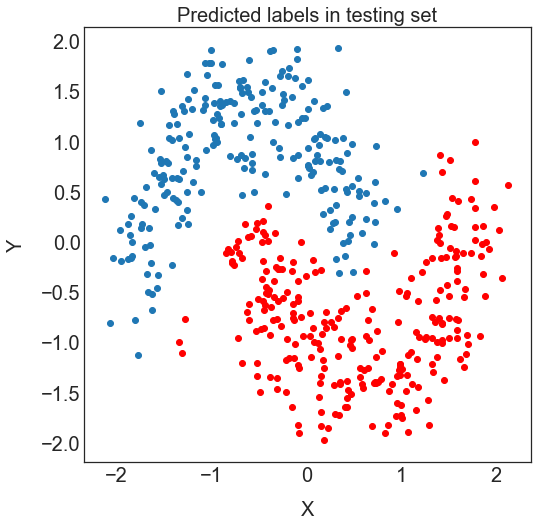

In [18]:
FONTSIZE = 20
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')

ax.legend(loc='best', fontsize=FONTSIZE)
ax.set_xlabel('X', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('Y', fontsize=FONTSIZE, labelpad=15)
adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)
_ = ax.set_title('Predicted labels in testing set', fontsize=FONTSIZE)


# Plot the decision boundary

In [19]:
grid = np.mgrid[-2.5:2.5:100j, -2.5:2.5:100j].astype(floatX)
grid_2d = grid.reshape(2, -1).T
ppc = sample_proba(grid_2d, 500)

In [20]:
ppc.shape

(500, 10000)

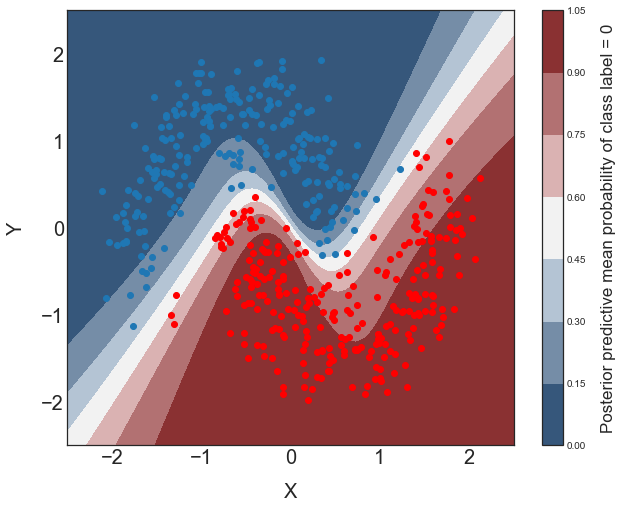

In [21]:
cmap = sbn.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(1, figsize=(10, 8))

contour = ax.contourf(grid[0], grid[1], ppc.mean(axis=0).reshape(100, 100), cmap=cmap)

ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_xlabel('X', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('Y', fontsize=FONTSIZE, labelpad=15)
adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)

cbar = plt.colorbar(contour, ax=ax)
_ = cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0', 
                   fontsize=FONTSIZE*0.85, labelpad=15)


# Plot uncertainty in predicted value

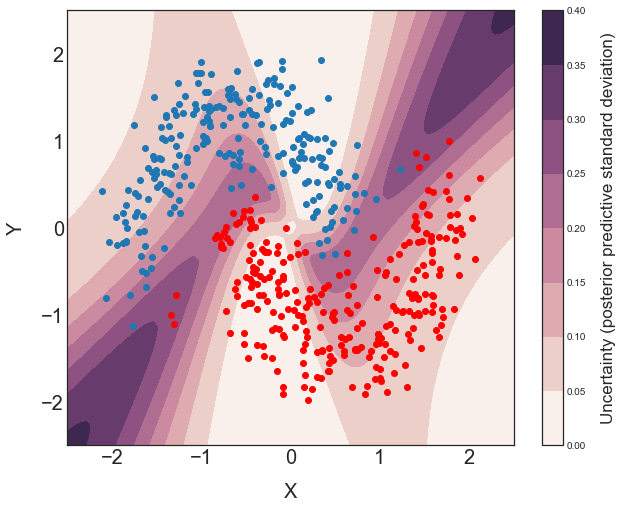

In [22]:
cmap = sbn.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(1, figsize=(10, 8))

contour = ax.contourf(grid[0], grid[1], ppc.std(axis=0).reshape(100, 100), cmap=cmap)

ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_xlabel('X', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('Y', fontsize=FONTSIZE, labelpad=15)
adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)

cbar = plt.colorbar(contour, ax=ax)
_ = cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)', 
                       fontsize=FONTSIZE*0.85, labelpad=15)
